<a href="https://colab.research.google.com/github/utyabia/1-notebook/blob/main/PyTorch_Computer_Vision_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. What are 3 areas in industry where computer vision is currently being used?

Healthcare: Computer vision is used for diagnostic tools, such as identifying diseases from medical imaging (X-rays, MRIs, etc.).

Retail: Computer vision is used for inventory management, product recommendations, and customer behavior analysis (e.g., cashier-less stores like Amazon Go).

Automotive: Self-driving cars use computer vision for object detection, lane recognition, and navigation.



2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting occurs when a machine learning model learns the details and noise in the training data to the extent that it negatively impacts the performance of the model on new, unseen data.

3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.

Regularization (L1/L2): Adding a penalty term to the loss function can help prevent overfitting by discouraging overly complex models.

Early Stopping: Monitoring the performance on a validation set and stopping training when performance begins to degrade helps prevent overfitting.

Data Augmentation: Increasing the diversity of the training set by applying random transformations (rotations, flips, etc.) can help the model generalize better.

4. Spend 20-minutes reading and clicking through the CNN Explainer website.
Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.


5. Load the torchvision.datasets.MNIST() train and test datasets.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 40.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 991kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.95MB/s]


6. Visualize at least 5 different samples of the MNIST training dataset.

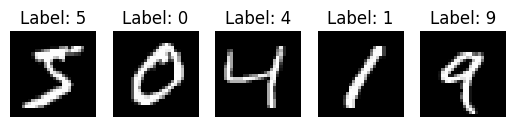

In [2]:
import matplotlib.pyplot as plt

# Visualize 5 random samples from the MNIST dataset
for i in range(5):
    image, label = train_data[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()



7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [3]:
from torch.utils.data import DataLoader

# Create DataLoader for train and test datasets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


8. Recreate model_2 used in notebook 03 (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [4]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*7*7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*7*7)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = TinyVGG()


9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [5]:
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to train the model for 5 epochs
def train_model(model, train_loader, device):
    model.train()
    start_time = time.time()

    for epoch in range(5):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}")

    end_time = time.time()
    print(f"Training time: {end_time - start_time:.4f} seconds")

train_model(model, train_loader, device)


Epoch [1/5], Loss: 0.2055
Epoch [2/5], Loss: 0.0589
Epoch [3/5], Loss: 0.0425
Epoch [4/5], Loss: 0.0318
Epoch [5/5], Loss: 0.0247
Training time: 185.1981 seconds


10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

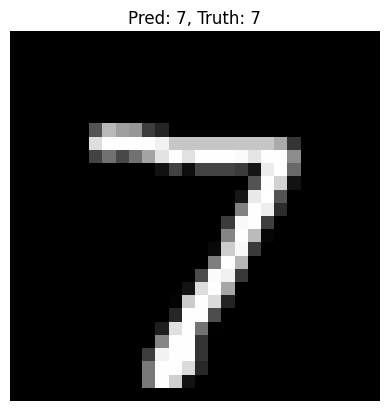

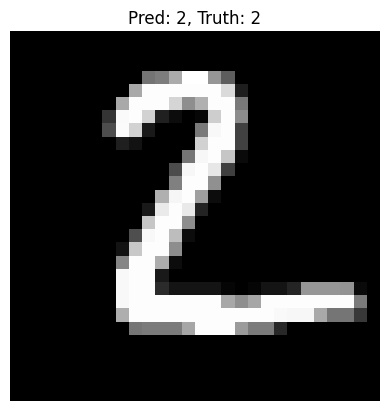

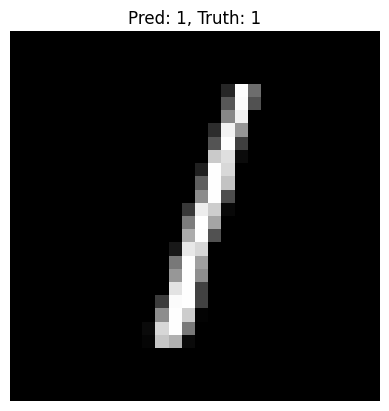

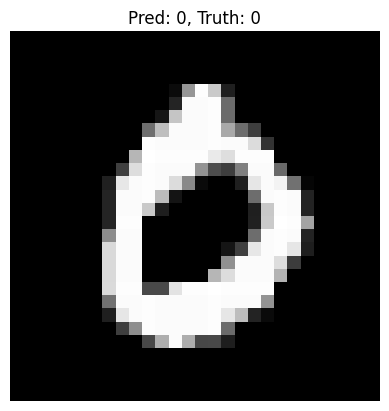

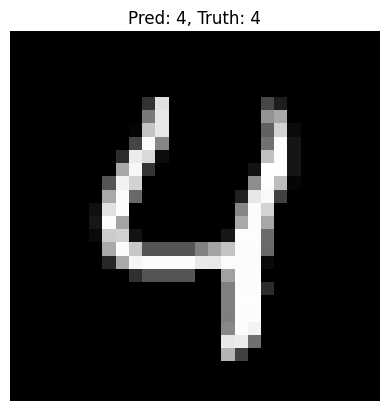

In [6]:
# Make predictions and visualize
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot the images along with their predictions and labels
for i in range(5):
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}, Truth: {labels[i].item()}")
    plt.axis('off')
    plt.show()


11. Plot a confusion matrix comparing your model's predictions to the truth labels.

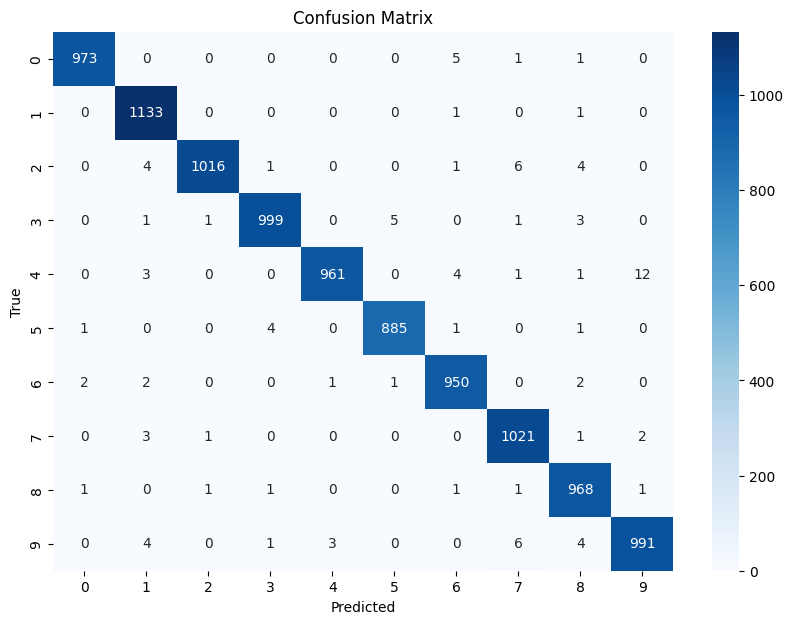

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
model.eval()
all_preds = []
all_labels = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [8]:
# Create a random tensor of shape [1, 3, 64, 64]
x = torch.randn(1, 3, 64, 64)

# Define a Conv2d layer with varying hyperparameters
conv_layer = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Example settings
output = conv_layer(x)

print("Output shape after Conv2d:", output.shape)

# Try changing kernel_size and observe the effect
conv_layer = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
output = conv_layer(x)

print("Output shape after Conv2d with kernel_size=5:", output.shape)


Output shape after Conv2d: torch.Size([1, 16, 64, 64])
Output shape after Conv2d with kernel_size=5: torch.Size([1, 16, 64, 64])


13. Use a model similar to the trained model_2 from notebook 03 to make predictions on the test torchvision.datasets.FashionMNIST dataset.
Then plot some predictions where the model was wrong alongside what the label of the image should've been.
After visualing these predictions do you think it's more of a modelling error or a data error?
As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [9]:
from torchvision import datasets, transforms

# Transform to normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load train and test datasets
fashion_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Create DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(fashion_train, batch_size=32, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=32, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.77MB/s]


In [10]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


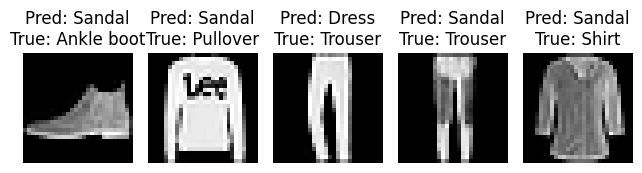

In [11]:
import matplotlib.pyplot as plt

# FashionMNIST class labels
class_names = fashion_train.classes

# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyVGG().to(device)

# (Optional) Load pre-trained model weights if available

# Evaluate mode
model.eval()

# Find incorrect predictions
wrong_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                wrong_preds.append((img.cpu(), pred.item(), label.item()))
            if len(wrong_preds) >= 5:
                break
        if len(wrong_preds) >= 5:
            break

# Plot 5 incorrect predictions
for i, (img, pred, label) in enumerate(wrong_preds):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
